# Neural Style Transfer (NST)
This notebook contains an implementation of the NST algorithm as proposed in "A Neural Algorithm of Artistic Style" which can be found here: https://arxiv.org/pdf/1508.06576
The notebook serves as a playground to test the capabilities with different images, styles, configurations, etc.

In [1]:
import uuid
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


For NST the default model to be used for feature extraction is VGG-19 which has been pretrained for image recognition. Since it is kind of useless to train VGG again from scratch, we can use the pretrained version from the TorchVision model library.

In [3]:
class NST_VGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_content_idx = [21]
        self.layer_style_idx = [0, 5, 10, 19, 28]
        self.model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features[:29]

        # Freeze the model parameters
        for param in self.model.parameters():
            param.requires_grad = False
    
    def forward(self, x):
        content_features = []
        style_features = []
        
        for layer_idx, layer in enumerate(self.model):
            x = layer(x)
            
            if layer_idx in self.layer_content_idx:
                content_features.append(x)
            
            if layer_idx in self.layer_style_idx:
                style_features.append(x)
 
        return content_features, style_features

In [4]:
vgg = NST_VGG().to(device).eval()

The most important thing is of course to calculate the loss of the generated image, in order to push it towards the desired result.

There are two losses that need to be combined. First, there is the content loss which directly compares the feature maps from the content and generated images. This one ensures that the output image resembles the content image in form.
The second loss is the style loss, which compares the Gram matrices (representing the style in feature maps through repeating patterns and textures) of the style and generated images. This loss function pushes the generated image to apply the style from the style image.
By then combining these two losses we generate an image that contains the same content as the content image, in the style of the style image. By playing with the weights of these two losses, we can control how the generated images look like.

In [5]:
def calculate_gram_matrix(feature_map):
    # Extract dimensions
    _, n_channels, height, width = feature_map.shape
    
    # Flatten the feature map by reshaping it into (n_channels, height * width)
    features = feature_map.view(n_channels, height * width)
    
    # Calculate the Gram matrix as the product of the features with its transpose
    gram = torch.mm(features, features.t())
    
    return gram

In [6]:
def calculate_loss(generated_content_feature_maps, content_feature_maps, generated_style_feature_maps, style_grams, alpha, beta):
    # Calculate content loss as the MSE between the feature maps of the given layer
    # Looking at other implementations conv4_2 seems to be sufficient for the content loss
    content_loss = 0
    for content_features, generated_content_features in zip(content_feature_maps, generated_content_feature_maps):
        content_loss += torch.nn.functional.mse_loss(content_features, generated_content_features, reduction='mean')

    # Average content loss across layers
    #content_loss /= len(content_features)
    
    # Calculate the style loss using the Gram matrices
    style_loss = 0
    for style_gram, gen_feature_style in zip(style_grams, generated_style_feature_maps):
        generated_gram = calculate_gram_matrix(gen_feature_style)
        layer_style_loss = torch.nn.functional.mse_loss(generated_gram, style_gram)
        style_loss += layer_style_loss
    
    # Average style loss across layers
    #style_loss /= len(style_grams)

    # Combine the content and style losses with their respective weights
    total_loss = alpha * content_loss + beta * style_loss

    return total_loss, content_loss, style_loss    

Next up we can load in the content and the style image, then the generation process can begin.

Keep in mind it's better to have a similar dimension for both images (and larger images will require more memory).

In [33]:
# FILL IN IMAGE PATHS HERE
content_path = "content_images/crete_street.jpg" 
style_path = "style_images/starry_night.jpeg"      

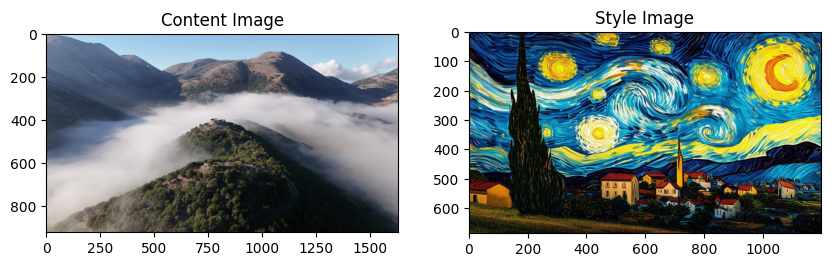

In [34]:
content_image = Image.open(content_path).convert("RGB")
style_image = Image.open(style_path).convert("RGB")

# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(content_image)
plt.title("Content Image")

plt.subplot(1, 2, 2)
plt.imshow(style_image)
plt.title("Style Image")

plt.show()

Now we start the generation process, there are a couple of steps we have to take:
- Normalize the images
- Compute the feature maps and Gram matrix for the content and style images
- Initialize the image we are generating (start from content image)
- Set up the optimizer
- Optimization loop
- Denormalize the generated image

But first a cell to set up the hyperparameters.

In [35]:
# Hyperparameters
num_steps = 3000  # Number of optimization steps
learning_rate = 0.001 # Step size when optimizing
alpha = 1        # Weight for content loss
beta = 1000       # Weight for style loss

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:50<00:00, 17.64it/s]


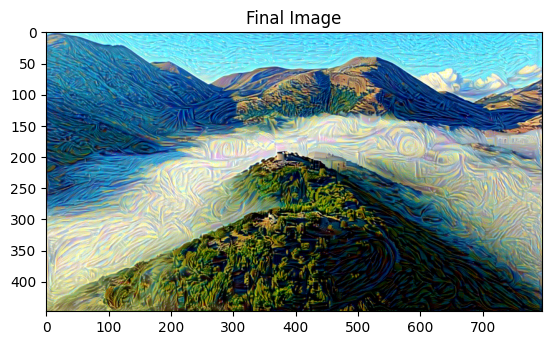

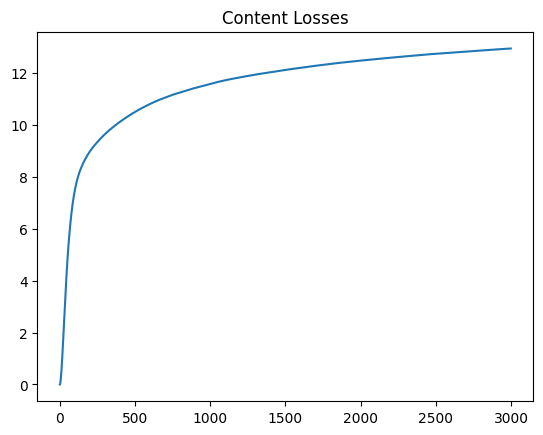

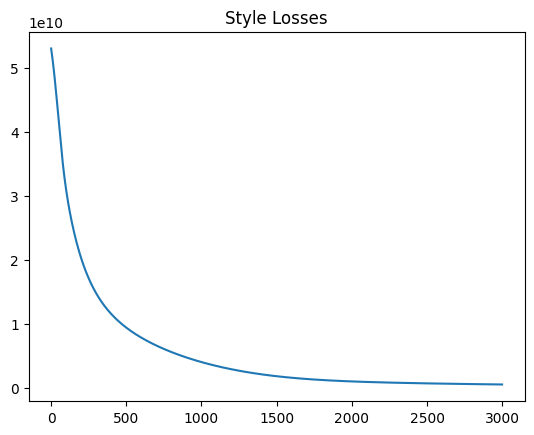

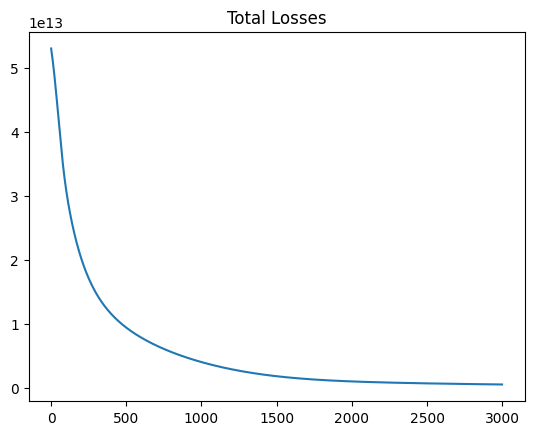

In [36]:
# Compute the mean and standard deviation of the content image
content_image_mean = torch.tensor([transforms.ToTensor()(content_image)[:, :, c].mean() for c in range(3)])
content_image_std = torch.tensor([transforms.ToTensor()(content_image)[:, :, c].std() for c in range(3)])

# Define preprocessing transformation using the content image's statistics
preprocess = transforms.Compose([
    transforms.Resize(448),
    transforms.ToTensor(),
    transforms.Normalize(content_image_mean, content_image_std)  # Use content image's mean and std
])

# Apply preprocessing
content_tensor = preprocess(content_image).unsqueeze(0)
content_tensor = content_tensor.to(device)
style_tensor = preprocess(style_image).unsqueeze(0).to(device)

# Pre-compute feature maps
content_features, _ = vgg(content_tensor)
_, style_features = vgg(style_tensor)

# Pre-compute Gram matrices
style_grams = [calculate_gram_matrix(feature_map) for feature_map in style_features]

# Initialize the generated image (starting with the content image)
generated_image = content_tensor.clone().requires_grad_(True).to(device)

# Set up the optimizer
optimizer = torch.optim.Adam([generated_image], lr=learning_rate)

content_losses = []
style_losses = []
total_losses = []

# Optimization loop
for step in tqdm(range(num_steps)):
    # Extract features from the generated image
    generated_content_features, generated_style_features = vgg(generated_image)
    
    # Compute the total loss
    total_loss, content_loss, style_loss = calculate_loss(
        generated_content_feature_maps=generated_content_features,
        content_feature_maps=content_features,
        generated_style_feature_maps=generated_style_features,
        style_grams=style_grams,
        alpha=alpha,
        beta=beta
    )
    
    # Backpropagation and optimization step
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    content_losses.append(content_loss.item())
    style_losses.append(style_loss.item())
    total_losses.append(total_loss.item())

# Denormalize the generated image
def denormalize_image(img, mean, std):
    # Denormalize using the content image's mean and std
    std = std.view(3, 1, 1)
    mean = mean.view(3, 1, 1)
    img = img * std + mean
    img = img.clamp(0, 1)
    return img

# Denormalize the final generated image
final_image = denormalize_image(generated_image.squeeze(0).cpu(), content_image_mean, content_image_std)

# Convert to PIL for visualization
final_image = transforms.ToPILImage()(final_image)

plt.imshow(final_image)
plt.title("Final Image")
plt.show()

plt.title('Content Losses')
plt.plot(content_losses)
plt.show()

plt.title('Style Losses')
plt.plot(style_losses)
plt.show()

plt.title('Total Losses')
plt.plot(total_losses)
plt.show()

# Generate a random filename
random_filename = f"final_image_{uuid.uuid4().hex}.png"
output_path = os.path.join("generated_images", random_filename)

# Save the image
final_image.save(output_path)